In [1]:
import json
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
#readin training and test datas
file_path = 'qa_dataset.json'

with open(file_path, 'r') as file:
    data = json.load(file)

In [3]:
#prepare model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [4]:
#customized dataset
class QADataset(Dataset):
    def __init__(self, tokenizer, data, block_size, train=True):
        self.train = True
        self.tokenizer = tokenizer
        self.questions_answers = []
        if not train:
            self.train = False
            self.answers = []

        with open(file_path, 'r') as file:
            for item in data:
                if train:
                    encoded = tokenizer.encode(f'Product: {item["product_name"]} Product Description: {item["product_description"]} Question: {item["question"]} Answer: {item["answer"]} {tokenizer.eos_token}', truncation=True, max_length=block_size, add_special_tokens=True)
                else:
                    encoded = tokenizer.encode(f'Product: {item["product_name"]} Product Description: {item["product_description"]} Question: {item["question"]}', truncation=True, max_length=block_size, add_special_tokens=False)
                    encoded2 = f'Product: {item["product_name"]} Product Description: {item["product_description"]} Question: {item["question"]} Answer: {item["answer"]}'
                    self.answers.append(encoded2)
                self.questions_answers.append(encoded)

    def __len__(self):
        return len(self.questions_answers)

    def __getitem__(self, idx):
        if self.train:
            return torch.tensor(self.questions_answers[idx], dtype=torch.long)
        else:
            return torch.tensor(self.questions_answers[idx], dtype=torch.long), self.answers[idx]

#padding functions
def collate_fn(batch):
    batch = pad_sequence(batch, batch_first=True, padding_value=tokenizer.pad_token_id)
    return batch
def collate_fn2(batch):
    questions, answers = zip(*batch)
    questions_tensor = [torch.tensor(question) for question in questions]
    max_len = max([q.size(0) for q in questions_tensor])
    questions_padded = torch.stack([torch.cat([torch.full((max_len - q.size(0),), tokenizer.pad_token_id), q]) for q in questions_tensor])
    attention_masks = torch.stack([torch.cat([torch.zeros(max_len - q.size(0)), torch.ones(q.size(0))]) for q in questions_tensor])
    return questions_padded, attention_masks, answers


In [5]:
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

In [6]:
def prepare_model():
    #prepare model
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token
    model = GPT2LMHeadModel.from_pretrained('gpt2')
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    return model, tokenizer

In [7]:
def training(model, train_loader, epoch, optimizer, loss_fn):
    # #hyper parameters
    # epochs = 25
    
    # #optimizer
    # optimizer = AdamW(model.parameters(), lr=5e-5)
    
    # #loss function
    # loss_fn = torch.nn.CrossEntropyLoss()
    
    epoch_losses = []
    
    # Training loop
    model.train()
    for epoch in range(epoch):
        total_loss = 0
        for batch in tqdm(train_loader):
            inputs = batch.to(device)
            labels = batch.to(device)
            outputs = model(inputs, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        avg_loss = total_loss/len(train_loader)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch+1} finished. Loss: {avg_loss}")
    return epoch_losses

In [8]:
def plot(epoch_losses, fold):
    # Plotting the training loss
    plt.plot(epoch_losses, label=f'Training Loss Fold {fold}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss Over Epochs Fold {fold}')
    plt.legend()
    plt.show()

In [9]:
def testing(model, test_loader):
    temp = tokenizer.padding_side
    tokenizer.padding_side = 'left'
    temp2 = model.config.pad_token_id
    model.config.pad_token_id = model.config.eos_token_id
    
    #switch to evaluation mode
    model.eval()
    
    #BLEU scores list
    bleu_scores = []
    
    for batch in tqdm(test_loader):
        encoded_questions, attention_masks, correct_answers = batch
        encoded_questions = encoded_questions.to(device)
        attention_masks = attention_masks.to(device)
        
        for i in range(encoded_questions.size(0)):
            with torch.no_grad():
                output = model.generate(encoded_questions[i].unsqueeze(0), 
                                        attention_mask=attention_masks[i].unsqueeze(0),
                                        max_length=512)  # Set `your_max_length` appropriately
                generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
                reference = correct_answers[i].split()
                candidate = generated_text.split()
    
                #calculate BLEU score
                score = sentence_bleu([reference], candidate)
                bleu_scores.append(score)
    
    #calculate average BLEU score across all items
    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    return avg_bleu_score

### train 1

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 143/143 [00:30<00:00,  4.74it/s]


Epoch 1 finished. Loss: 1.960523667035403


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 2 finished. Loss: 1.6094846967216971


100%|██████████| 143/143 [00:30<00:00,  4.70it/s]


Epoch 3 finished. Loss: 1.4206441332410265


100%|██████████| 143/143 [00:30<00:00,  4.72it/s]


Epoch 4 finished. Loss: 1.3019078303050329


100%|██████████| 143/143 [00:29<00:00,  4.82it/s]


Epoch 5 finished. Loss: 1.2042125307179832


100%|██████████| 143/143 [00:30<00:00,  4.71it/s]


Epoch 6 finished. Loss: 1.0515146670224784


100%|██████████| 143/143 [00:30<00:00,  4.71it/s]


Epoch 7 finished. Loss: 0.9550225530471002


100%|██████████| 143/143 [00:30<00:00,  4.72it/s]


Epoch 8 finished. Loss: 0.8883837494816813


100%|██████████| 143/143 [00:30<00:00,  4.74it/s]


Epoch 9 finished. Loss: 0.8168988807218058


100%|██████████| 143/143 [00:29<00:00,  4.84it/s]


Epoch 10 finished. Loss: 0.7826857250053566


100%|██████████| 143/143 [00:30<00:00,  4.70it/s]


Epoch 11 finished. Loss: 0.6897165504368868


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 12 finished. Loss: 0.6546097068519859


100%|██████████| 143/143 [00:30<00:00,  4.61it/s]


Epoch 13 finished. Loss: 0.5818194957463058


100%|██████████| 143/143 [00:30<00:00,  4.73it/s]


Epoch 14 finished. Loss: 0.5621249040106794


100%|██████████| 143/143 [00:30<00:00,  4.70it/s]


Epoch 15 finished. Loss: 0.5069978041248722


100%|██████████| 143/143 [00:30<00:00,  4.70it/s]


Epoch 16 finished. Loss: 0.4780700669422016


100%|██████████| 143/143 [00:30<00:00,  4.68it/s]


Epoch 17 finished. Loss: 0.4454302687744994


100%|██████████| 143/143 [00:29<00:00,  4.77it/s]


Epoch 18 finished. Loss: 0.4198742780860487


100%|██████████| 143/143 [00:29<00:00,  4.80it/s]


Epoch 19 finished. Loss: 0.38826251415522783


100%|██████████| 143/143 [00:30<00:00,  4.73it/s]


Epoch 20 finished. Loss: 0.3530080235087788


100%|██████████| 143/143 [00:30<00:00,  4.68it/s]


Epoch 21 finished. Loss: 0.3277451203732224


100%|██████████| 143/143 [00:30<00:00,  4.72it/s]


Epoch 22 finished. Loss: 0.30443101454448035


100%|██████████| 143/143 [00:30<00:00,  4.69it/s]


Epoch 23 finished. Loss: 0.2831785871119766


100%|██████████| 143/143 [00:30<00:00,  4.66it/s]


Epoch 24 finished. Loss: 0.25819459323074434


100%|██████████| 143/143 [00:30<00:00,  4.66it/s]


Epoch 25 finished. Loss: 0.24041368260041818


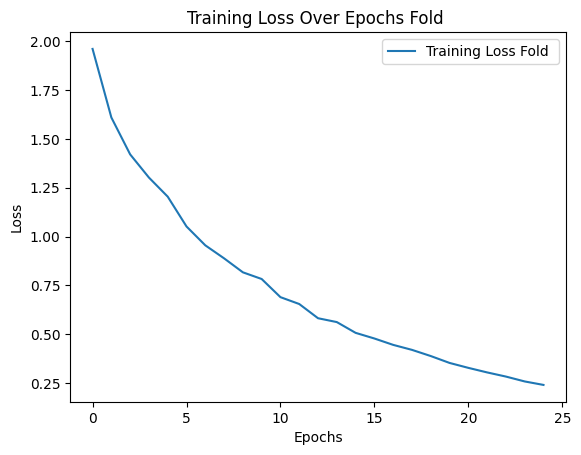

  0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_4497/2159941939.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  questions_tensor = [torch.tensor(question) for question in questions]
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
 36%|███▌      | 58/163 [00:42<00:59,  1.76it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 512, but `max_length` is set to 512. 

Average BLEU Score: 0.7694795275655861


In [10]:
#hyper parameters
epochs = 25

#optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "")
print(f"Average BLEU Score: {testing(model, test_loader)}")

In [12]:
#saving model
model.save_pretrained('./gpt2-qa-finetuned-25-epoch')

### K-fold

In [13]:
#k-fold (5)
kf = KFold(n_splits=5, shuffle=True)

FOLD 0
--------------------------------


100%|██████████| 163/163 [00:34<00:00,  4.69it/s]


Epoch 1 finished. Loss: 1.962772321847319


100%|██████████| 163/163 [00:34<00:00,  4.67it/s]


Epoch 2 finished. Loss: 1.6673412699640895


100%|██████████| 163/163 [00:35<00:00,  4.64it/s]


Epoch 3 finished. Loss: 1.5090033057277188


100%|██████████| 163/163 [00:34<00:00,  4.71it/s]


Epoch 4 finished. Loss: 1.3974525039912733


100%|██████████| 163/163 [00:34<00:00,  4.66it/s]


Epoch 5 finished. Loss: 1.2655578548191515


100%|██████████| 163/163 [00:34<00:00,  4.74it/s]


Epoch 6 finished. Loss: 1.190496369373579


100%|██████████| 163/163 [00:35<00:00,  4.63it/s]


Epoch 7 finished. Loss: 1.0596840699757535


100%|██████████| 163/163 [00:35<00:00,  4.66it/s]


Epoch 8 finished. Loss: 0.9756303842813691


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 9 finished. Loss: 0.9013370054265473


100%|██████████| 163/163 [00:34<00:00,  4.66it/s]


Epoch 10 finished. Loss: 0.8295013685167932


100%|██████████| 163/163 [00:35<00:00,  4.63it/s]


Epoch 11 finished. Loss: 0.7679637805815854


100%|██████████| 163/163 [00:34<00:00,  4.72it/s]


Epoch 12 finished. Loss: 0.7230241209085734


100%|██████████| 163/163 [00:34<00:00,  4.68it/s]


Epoch 13 finished. Loss: 0.6692734031589485


100%|██████████| 163/163 [00:34<00:00,  4.67it/s]


Epoch 14 finished. Loss: 0.6161894111728375


100%|██████████| 163/163 [00:34<00:00,  4.68it/s]


Epoch 15 finished. Loss: 0.5807609735456712


100%|██████████| 163/163 [00:34<00:00,  4.67it/s]


Epoch 16 finished. Loss: 0.5323701787945683


100%|██████████| 163/163 [00:35<00:00,  4.59it/s]


Epoch 17 finished. Loss: 0.4902757881609209


100%|██████████| 163/163 [00:34<00:00,  4.71it/s]


Epoch 18 finished. Loss: 0.46913045333938364


100%|██████████| 163/163 [00:34<00:00,  4.72it/s]


Epoch 19 finished. Loss: 0.4369672167520582


100%|██████████| 163/163 [00:35<00:00,  4.66it/s]


Epoch 20 finished. Loss: 0.4006115843547634


100%|██████████| 163/163 [00:34<00:00,  4.67it/s]


Epoch 21 finished. Loss: 0.37479199423380427


100%|██████████| 163/163 [00:35<00:00,  4.64it/s]


Epoch 22 finished. Loss: 0.34421931984234444


100%|██████████| 163/163 [00:35<00:00,  4.61it/s]


Epoch 23 finished. Loss: 0.3174874689315726


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 24 finished. Loss: 0.29819110118172654


100%|██████████| 163/163 [00:35<00:00,  4.62it/s]


Epoch 25 finished. Loss: 0.2742457759618028


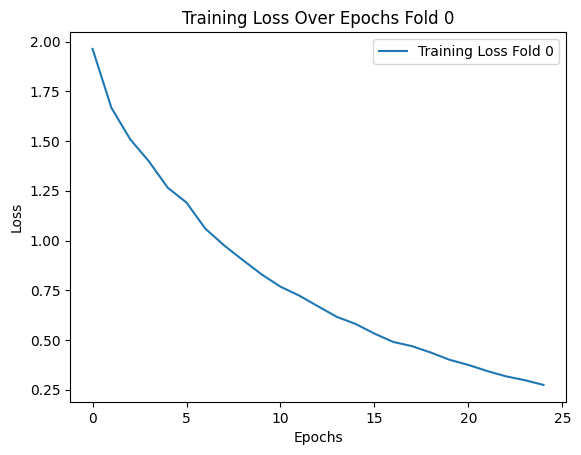

  0%|          | 0/109 [00:00<?, ?it/s]/tmp/ipykernel_4497/2159941939.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  questions_tensor = [torch.tensor(question) for question in questions]
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
  1%|          | 1/109 [00:00<00:34,  3.13it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1281: UserWarning: Input length of input_ids is 512, but `max_length` is set to 512. T

0.7627075450848558
FOLD 1
--------------------------------


100%|██████████| 163/163 [00:34<00:00,  4.79it/s]


Epoch 1 finished. Loss: 1.9247574733078845


100%|██████████| 163/163 [00:34<00:00,  4.76it/s]


Epoch 2 finished. Loss: 1.6167166265973285


100%|██████████| 163/163 [00:33<00:00,  4.85it/s]


Epoch 3 finished. Loss: 1.4879755911651564


100%|██████████| 163/163 [00:33<00:00,  4.83it/s]


Epoch 4 finished. Loss: 1.3435204303337753


100%|██████████| 163/163 [00:34<00:00,  4.79it/s]


Epoch 5 finished. Loss: 1.2225195085344138


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 6 finished. Loss: 1.0814796424716528


100%|██████████| 163/163 [00:33<00:00,  4.84it/s]


Epoch 7 finished. Loss: 1.0290916655326914


100%|██████████| 163/163 [00:34<00:00,  4.75it/s]


Epoch 8 finished. Loss: 0.9254331756954545


100%|██████████| 163/163 [00:33<00:00,  4.94it/s]


Epoch 9 finished. Loss: 0.8856623366566524


100%|██████████| 163/163 [00:33<00:00,  4.82it/s]


Epoch 10 finished. Loss: 0.790663461560852


100%|██████████| 163/163 [00:34<00:00,  4.78it/s]


Epoch 11 finished. Loss: 0.736596767704911


100%|██████████| 163/163 [00:33<00:00,  4.82it/s]


Epoch 12 finished. Loss: 0.6837611026559139


100%|██████████| 163/163 [00:34<00:00,  4.78it/s]


Epoch 13 finished. Loss: 0.6330898571416644


100%|██████████| 163/163 [00:34<00:00,  4.74it/s]


Epoch 14 finished. Loss: 0.581268836567007


100%|██████████| 163/163 [00:34<00:00,  4.79it/s]


Epoch 15 finished. Loss: 0.5459446769002025


100%|██████████| 163/163 [00:33<00:00,  4.88it/s]


Epoch 16 finished. Loss: 0.5200554471622947


100%|██████████| 163/163 [00:33<00:00,  4.86it/s]


Epoch 17 finished. Loss: 0.4745201800315658


100%|██████████| 163/163 [00:34<00:00,  4.77it/s]


Epoch 18 finished. Loss: 0.43662342031492046


100%|██████████| 163/163 [00:33<00:00,  4.81it/s]


Epoch 19 finished. Loss: 0.4137213832578776


100%|██████████| 163/163 [00:33<00:00,  4.81it/s]


Epoch 20 finished. Loss: 0.3792520710295695


100%|██████████| 163/163 [00:33<00:00,  4.86it/s]


Epoch 21 finished. Loss: 0.3562086431161026


100%|██████████| 163/163 [00:34<00:00,  4.69it/s]


Epoch 22 finished. Loss: 0.31396194012618506


100%|██████████| 163/163 [00:34<00:00,  4.76it/s]


Epoch 23 finished. Loss: 0.29825470404573745


100%|██████████| 163/163 [00:34<00:00,  4.75it/s]


Epoch 24 finished. Loss: 0.27491589023108864


100%|██████████| 163/163 [00:33<00:00,  4.81it/s]

Epoch 25 finished. Loss: 0.2604623007719502


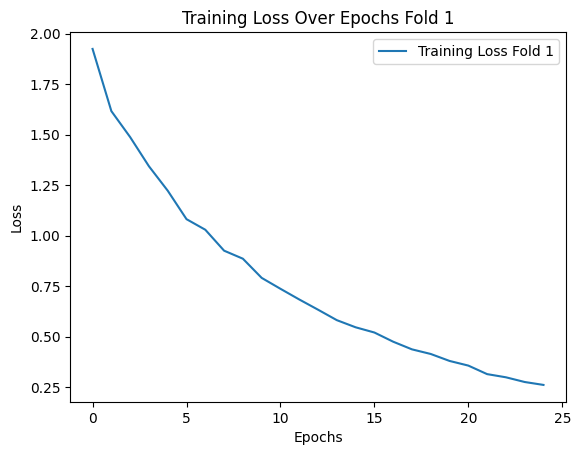

100%|██████████| 109/109 [01:13<00:00,  1.48it/s]


0.7622495034030937
FOLD 2
--------------------------------


100%|██████████| 163/163 [00:34<00:00,  4.77it/s]


Epoch 1 finished. Loss: 1.9612492366802472


100%|██████████| 163/163 [00:34<00:00,  4.78it/s]


Epoch 2 finished. Loss: 1.6852926904438463


100%|██████████| 163/163 [00:34<00:00,  4.66it/s]


Epoch 3 finished. Loss: 1.4935969066766142


100%|██████████| 163/163 [00:34<00:00,  4.73it/s]


Epoch 4 finished. Loss: 1.3674418055938065


100%|██████████| 163/163 [00:34<00:00,  4.73it/s]


Epoch 5 finished. Loss: 1.24012509957413


100%|██████████| 163/163 [00:35<00:00,  4.63it/s]


Epoch 6 finished. Loss: 1.1080209444636948


100%|██████████| 163/163 [00:33<00:00,  4.84it/s]


Epoch 7 finished. Loss: 1.06699178226155


100%|██████████| 163/163 [00:33<00:00,  4.85it/s]


Epoch 8 finished. Loss: 0.9722887460439483


100%|██████████| 163/163 [00:34<00:00,  4.68it/s]


Epoch 9 finished. Loss: 0.8687006006577264


100%|██████████| 163/163 [00:34<00:00,  4.76it/s]


Epoch 10 finished. Loss: 0.8122461013998722


100%|██████████| 163/163 [00:35<00:00,  4.60it/s]


Epoch 11 finished. Loss: 0.7187533780841008


100%|██████████| 163/163 [00:35<00:00,  4.62it/s]


Epoch 12 finished. Loss: 0.6848649394475609


100%|██████████| 163/163 [00:33<00:00,  4.86it/s]


Epoch 13 finished. Loss: 0.6738029996310275


100%|██████████| 163/163 [00:34<00:00,  4.72it/s]


Epoch 14 finished. Loss: 0.6033906178788905


100%|██████████| 163/163 [00:34<00:00,  4.68it/s]


Epoch 15 finished. Loss: 0.5528331082657071


100%|██████████| 163/163 [00:34<00:00,  4.67it/s]


Epoch 16 finished. Loss: 0.5143096274210631


100%|██████████| 163/163 [00:34<00:00,  4.73it/s]


Epoch 17 finished. Loss: 0.4931006213090171


100%|██████████| 163/163 [00:35<00:00,  4.63it/s]


Epoch 18 finished. Loss: 0.4418070019205655


100%|██████████| 163/163 [00:34<00:00,  4.69it/s]


Epoch 19 finished. Loss: 0.4116833491559409


100%|██████████| 163/163 [00:34<00:00,  4.69it/s]


Epoch 20 finished. Loss: 0.38932012762028745


100%|██████████| 163/163 [00:35<00:00,  4.62it/s]


Epoch 21 finished. Loss: 0.3538892978996587


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 22 finished. Loss: 0.3350641159740694


100%|██████████| 163/163 [00:34<00:00,  4.73it/s]


Epoch 23 finished. Loss: 0.3147313226402903


100%|██████████| 163/163 [00:34<00:00,  4.74it/s]


Epoch 24 finished. Loss: 0.2915461742621989


100%|██████████| 163/163 [00:34<00:00,  4.78it/s]


Epoch 25 finished. Loss: 0.2725340826836832


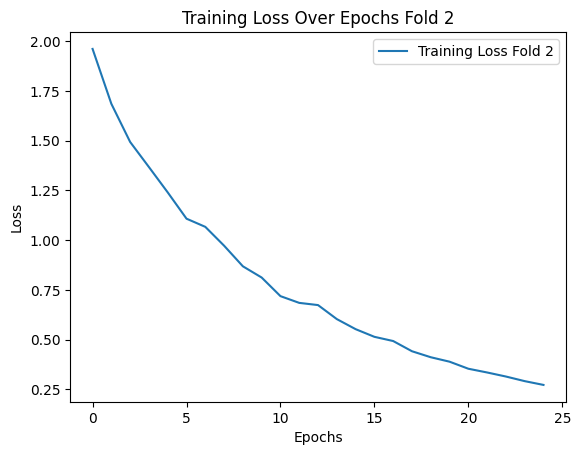

100%|██████████| 109/109 [01:17<00:00,  1.40it/s]


0.7547937106749399
FOLD 3
--------------------------------


100%|██████████| 163/163 [00:33<00:00,  4.81it/s]


Epoch 1 finished. Loss: 1.9813510252654187


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 2 finished. Loss: 1.6418546061574315


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 3 finished. Loss: 1.5021862808180733


100%|██████████| 163/163 [00:34<00:00,  4.77it/s]


Epoch 4 finished. Loss: 1.3841745235437264


100%|██████████| 163/163 [00:34<00:00,  4.68it/s]


Epoch 5 finished. Loss: 1.2426565124944675


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 6 finished. Loss: 1.1268763139935358


100%|██████████| 163/163 [00:36<00:00,  4.52it/s]


Epoch 7 finished. Loss: 0.9946367495630416


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 8 finished. Loss: 0.9493829320910518


100%|██████████| 163/163 [00:34<00:00,  4.66it/s]


Epoch 9 finished. Loss: 0.8687753743189244


100%|██████████| 163/163 [00:34<00:00,  4.73it/s]


Epoch 10 finished. Loss: 0.8147556964605133


100%|██████████| 163/163 [00:34<00:00,  4.76it/s]


Epoch 11 finished. Loss: 0.7570325542081353


100%|██████████| 163/163 [00:34<00:00,  4.75it/s]


Epoch 12 finished. Loss: 0.707461381068259


100%|██████████| 163/163 [00:34<00:00,  4.71it/s]


Epoch 13 finished. Loss: 0.6531850600535153


100%|██████████| 163/163 [00:35<00:00,  4.65it/s]


Epoch 14 finished. Loss: 0.5960022175421744


100%|██████████| 163/163 [00:34<00:00,  4.67it/s]


Epoch 15 finished. Loss: 0.5566878768564002


100%|██████████| 163/163 [00:33<00:00,  4.83it/s]


Epoch 16 finished. Loss: 0.543259826723052


100%|██████████| 163/163 [00:34<00:00,  4.76it/s]


Epoch 17 finished. Loss: 0.49088956525355026


100%|██████████| 163/163 [00:34<00:00,  4.78it/s]


Epoch 18 finished. Loss: 0.4572120864698492


100%|██████████| 163/163 [00:34<00:00,  4.71it/s]


Epoch 19 finished. Loss: 0.4182298421128396


100%|██████████| 163/163 [00:34<00:00,  4.67it/s]


Epoch 20 finished. Loss: 0.3831688466430442


100%|██████████| 163/163 [00:34<00:00,  4.79it/s]


Epoch 21 finished. Loss: 0.3687123081252619


100%|██████████| 163/163 [00:34<00:00,  4.68it/s]


Epoch 22 finished. Loss: 0.32912228114765846


100%|██████████| 163/163 [00:35<00:00,  4.60it/s]


Epoch 23 finished. Loss: 0.30056115765513086


100%|██████████| 163/163 [00:35<00:00,  4.64it/s]


Epoch 24 finished. Loss: 0.28312261457457866


100%|██████████| 163/163 [00:34<00:00,  4.71it/s]


Epoch 25 finished. Loss: 0.26633933136251076


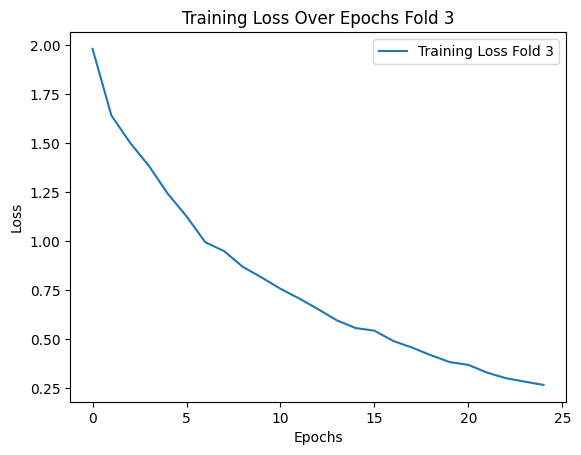

100%|██████████| 109/109 [01:14<00:00,  1.47it/s]


0.7485971929287031
FOLD 4
--------------------------------


100%|██████████| 163/163 [00:33<00:00,  4.84it/s]


Epoch 1 finished. Loss: 1.9599245954876297


100%|██████████| 163/163 [00:33<00:00,  4.84it/s]


Epoch 2 finished. Loss: 1.667292532379642


100%|██████████| 163/163 [00:34<00:00,  4.75it/s]


Epoch 3 finished. Loss: 1.5075425030263656


100%|██████████| 163/163 [00:34<00:00,  4.71it/s]


Epoch 4 finished. Loss: 1.3545284958704848


100%|██████████| 163/163 [00:34<00:00,  4.79it/s]


Epoch 5 finished. Loss: 1.2534469501372496


100%|██████████| 163/163 [00:33<00:00,  4.80it/s]


Epoch 6 finished. Loss: 1.1455219205171785


100%|██████████| 163/163 [00:34<00:00,  4.79it/s]


Epoch 7 finished. Loss: 1.0408177083255323


100%|██████████| 163/163 [00:34<00:00,  4.71it/s]


Epoch 8 finished. Loss: 0.93676740059092


100%|██████████| 163/163 [00:33<00:00,  4.80it/s]


Epoch 9 finished. Loss: 0.8900871796110656


100%|██████████| 163/163 [00:34<00:00,  4.75it/s]


Epoch 10 finished. Loss: 0.80906338523502


100%|██████████| 163/163 [00:34<00:00,  4.74it/s]


Epoch 11 finished. Loss: 0.7524604927177078


100%|██████████| 163/163 [00:34<00:00,  4.72it/s]


Epoch 12 finished. Loss: 0.6980214290823673


100%|██████████| 163/163 [00:34<00:00,  4.72it/s]


Epoch 13 finished. Loss: 0.6372575420726296


100%|██████████| 163/163 [00:33<00:00,  4.80it/s]


Epoch 14 finished. Loss: 0.6058796374527223


100%|██████████| 163/163 [00:33<00:00,  4.82it/s]


Epoch 15 finished. Loss: 0.5638892455883553


100%|██████████| 163/163 [00:34<00:00,  4.75it/s]


Epoch 16 finished. Loss: 0.5180918279966694


100%|██████████| 163/163 [00:34<00:00,  4.68it/s]


Epoch 17 finished. Loss: 0.4731918999388174


100%|██████████| 163/163 [00:33<00:00,  4.82it/s]


Epoch 18 finished. Loss: 0.45665222808627265


100%|██████████| 163/163 [00:33<00:00,  4.87it/s]


Epoch 19 finished. Loss: 0.4265571528234365


100%|██████████| 163/163 [00:34<00:00,  4.75it/s]


Epoch 20 finished. Loss: 0.38824175700453895


100%|██████████| 163/163 [00:34<00:00,  4.79it/s]


Epoch 21 finished. Loss: 0.3602847849116004


100%|██████████| 163/163 [00:34<00:00,  4.74it/s]


Epoch 22 finished. Loss: 0.3329374272764826


100%|██████████| 163/163 [00:34<00:00,  4.70it/s]


Epoch 23 finished. Loss: 0.3087528429331224


100%|██████████| 163/163 [00:34<00:00,  4.67it/s]


Epoch 24 finished. Loss: 0.2794053222229876


100%|██████████| 163/163 [00:34<00:00,  4.71it/s]


Epoch 25 finished. Loss: 0.26609503939473556


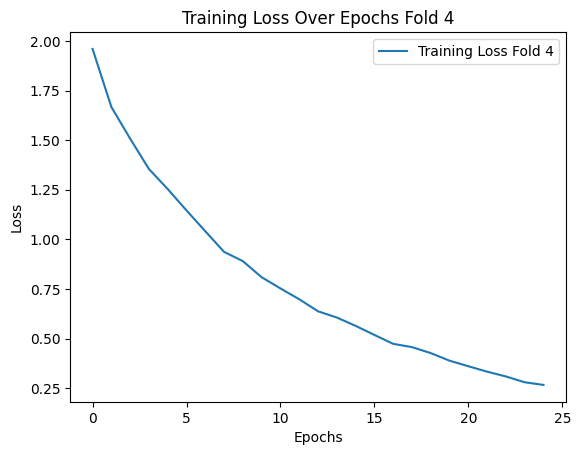

100%|██████████| 109/109 [00:55<00:00,  1.98it/s]

0.7781408692982921


In [15]:
for fold, (train_ids, test_ids) in enumerate(kf.split(data)):
    print(f'FOLD {fold}')
    print('--------------------------------')
    model, tokenizer = prepare_model()
    
    train_data = [data[i] for i in train_ids]
    test_data = [data[i] for i in test_ids]
    #create datasets for this fold
    train_dataset = QADataset(tokenizer, train_data, 512)
    test_dataset = QADataset(tokenizer, test_data, 512, train=False)

    #creating data loaders for each fold
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

    epoch_losses = training(model, train_loader, 25, AdamW(model.parameters(), lr=5e-5), torch.nn.CrossEntropyLoss())
    plot(epoch_losses, fold)
    print(testing(model, test_loader))

### Train 2

100%|██████████| 285/285 [00:27<00:00, 10.30it/s]


Epoch 1 finished. Loss: 2.539600878431086


100%|██████████| 285/285 [00:27<00:00, 10.33it/s]


Epoch 2 finished. Loss: 2.2373200905950448


100%|██████████| 285/285 [00:27<00:00, 10.25it/s]


Epoch 3 finished. Loss: 2.0876929797624286


100%|██████████| 285/285 [00:27<00:00, 10.26it/s]


Epoch 4 finished. Loss: 1.9975944487672104


100%|██████████| 285/285 [00:27<00:00, 10.29it/s]


Epoch 5 finished. Loss: 1.9329794737330654


100%|██████████| 285/285 [00:28<00:00, 10.14it/s]


Epoch 6 finished. Loss: 1.8199388794731675


100%|██████████| 285/285 [00:27<00:00, 10.38it/s]


Epoch 7 finished. Loss: 1.7882543731154057


100%|██████████| 285/285 [00:27<00:00, 10.23it/s]


Epoch 8 finished. Loss: 1.7033699577314811


100%|██████████| 285/285 [00:28<00:00, 10.11it/s]


Epoch 9 finished. Loss: 1.6209382931391398


100%|██████████| 285/285 [00:27<00:00, 10.23it/s]


Epoch 10 finished. Loss: 1.560655427188204


100%|██████████| 285/285 [00:28<00:00, 10.13it/s]


Epoch 11 finished. Loss: 1.5024411295589648


100%|██████████| 285/285 [00:27<00:00, 10.23it/s]


Epoch 12 finished. Loss: 1.4641715221237719


100%|██████████| 285/285 [00:28<00:00, 10.14it/s]


Epoch 13 finished. Loss: 1.403002909819285


100%|██████████| 285/285 [00:28<00:00, 10.15it/s]


Epoch 14 finished. Loss: 1.3404974788950201


100%|██████████| 285/285 [00:27<00:00, 10.26it/s]


Epoch 15 finished. Loss: 1.3135936106506148


100%|██████████| 285/285 [00:49<00:00,  5.75it/s]


Epoch 16 finished. Loss: 1.2930269402370118


100%|██████████| 285/285 [00:55<00:00,  5.13it/s]


Epoch 17 finished. Loss: 1.2363397338934112


100%|██████████| 285/285 [00:27<00:00, 10.32it/s]


Epoch 18 finished. Loss: 1.2108075679394237


100%|██████████| 285/285 [00:28<00:00, 10.16it/s]


Epoch 19 finished. Loss: 1.1469144981158408


100%|██████████| 285/285 [00:27<00:00, 10.27it/s]


Epoch 20 finished. Loss: 1.1297985467994422


100%|██████████| 285/285 [00:28<00:00, 10.15it/s]


Epoch 21 finished. Loss: 1.0803633635504204


100%|██████████| 285/285 [00:27<00:00, 10.31it/s]


Epoch 22 finished. Loss: 1.0849692697064919


100%|██████████| 285/285 [00:28<00:00, 10.15it/s]


Epoch 23 finished. Loss: 1.0343330111419946


100%|██████████| 285/285 [00:28<00:00, 10.14it/s]


Epoch 24 finished. Loss: 0.9900955530635097


100%|██████████| 285/285 [00:28<00:00, 10.15it/s]


Epoch 25 finished. Loss: 0.9685286351463251


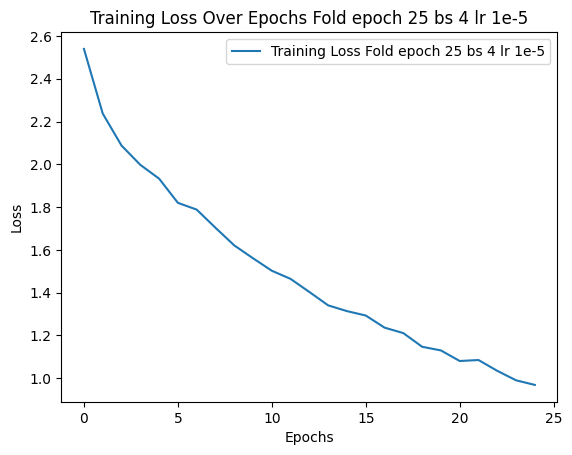

  0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_4497/2159941939.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  questions_tensor = [torch.tensor(question) for question in questions]
100%|██████████| 163/163 [01:17<00:00,  2.12it/s]

Average BLEU Score: 0.7922211407271589


In [16]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 25

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 25 bs 4 lr 1e-5")
print(f"Average BLEU Score: {testing(model, test_loader)}")

### Train 3

100%|██████████| 143/143 [00:29<00:00,  4.81it/s]


Epoch 1 finished. Loss: 2.2449033960595832


100%|██████████| 143/143 [00:29<00:00,  4.81it/s]


Epoch 2 finished. Loss: 1.89353404178486


100%|██████████| 143/143 [00:29<00:00,  4.83it/s]


Epoch 3 finished. Loss: 1.8282824046128279


100%|██████████| 143/143 [00:30<00:00,  4.76it/s]


Epoch 4 finished. Loss: 1.7336388476245053


100%|██████████| 143/143 [00:29<00:00,  4.91it/s]


Epoch 5 finished. Loss: 1.720850709851805


100%|██████████| 143/143 [00:29<00:00,  4.79it/s]


Epoch 6 finished. Loss: 1.6324855951996116


100%|██████████| 143/143 [00:30<00:00,  4.70it/s]


Epoch 7 finished. Loss: 1.5575825738740134


100%|██████████| 143/143 [00:30<00:00,  4.77it/s]


Epoch 8 finished. Loss: 1.5543235552894485


100%|██████████| 143/143 [00:30<00:00,  4.70it/s]


Epoch 9 finished. Loss: 1.494660287053435


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 10 finished. Loss: 1.4543322412284103


100%|██████████| 143/143 [00:30<00:00,  4.70it/s]


Epoch 11 finished. Loss: 1.410056113363146


100%|██████████| 143/143 [00:30<00:00,  4.72it/s]


Epoch 12 finished. Loss: 1.3720491461820536


100%|██████████| 143/143 [00:29<00:00,  4.78it/s]


Epoch 13 finished. Loss: 1.3750526379872035


100%|██████████| 143/143 [00:30<00:00,  4.76it/s]


Epoch 14 finished. Loss: 1.3226173336689289


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 15 finished. Loss: 1.2872576034152425


100%|██████████| 143/143 [00:30<00:00,  4.73it/s]


Epoch 16 finished. Loss: 1.247933923781335


100%|██████████| 143/143 [00:29<00:00,  4.83it/s]


Epoch 17 finished. Loss: 1.249494204571197


100%|██████████| 143/143 [00:30<00:00,  4.69it/s]


Epoch 18 finished. Loss: 1.182422116919831


100%|██████████| 143/143 [00:30<00:00,  4.66it/s]


Epoch 19 finished. Loss: 1.1317783244006283


100%|██████████| 143/143 [00:29<00:00,  4.79it/s]


Epoch 20 finished. Loss: 1.138478667586


100%|██████████| 143/143 [00:29<00:00,  4.77it/s]


Epoch 21 finished. Loss: 1.1128172807760173


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 22 finished. Loss: 1.0867516556819836


100%|██████████| 143/143 [00:29<00:00,  4.77it/s]


Epoch 23 finished. Loss: 1.061136819474347


100%|██████████| 143/143 [00:28<00:00,  4.94it/s]


Epoch 24 finished. Loss: 1.0804246905800345


100%|██████████| 143/143 [00:30<00:00,  4.71it/s]


Epoch 25 finished. Loss: 1.001431157538941


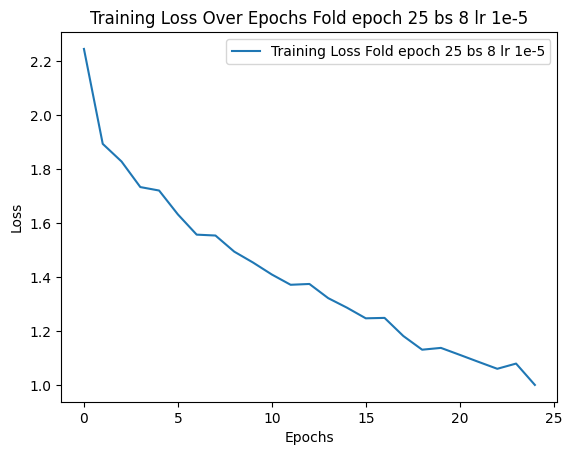

  0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_4497/2159941939.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  questions_tensor = [torch.tensor(question) for question in questions]
100%|██████████| 163/163 [01:16<00:00,  2.12it/s]

Average BLEU Score: 0.7912103241588467


In [17]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 25

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 25 bs 8 lr 1e-5")
print(f"Average BLEU Score: {testing(model, test_loader)}")

### Train 4

100%|██████████| 285/285 [00:27<00:00, 10.45it/s]


Epoch 1 finished. Loss: 2.1722580424526283


100%|██████████| 285/285 [00:28<00:00, 10.17it/s]


Epoch 2 finished. Loss: 1.5430701046659236


100%|██████████| 285/285 [00:27<00:00, 10.20it/s]


Epoch 3 finished. Loss: 1.2241734222361915


100%|██████████| 285/285 [00:27<00:00, 10.18it/s]


Epoch 4 finished. Loss: 0.9920299215274945


100%|██████████| 285/285 [00:28<00:00, 10.18it/s]


Epoch 5 finished. Loss: 0.8426891587282482


100%|██████████| 285/285 [00:27<00:00, 10.20it/s]


Epoch 6 finished. Loss: 0.6980201454539048


100%|██████████| 285/285 [00:28<00:00, 10.10it/s]


Epoch 7 finished. Loss: 0.5702877195257889


100%|██████████| 285/285 [00:27<00:00, 10.26it/s]


Epoch 8 finished. Loss: 0.49651747986412886


100%|██████████| 285/285 [00:27<00:00, 10.26it/s]


Epoch 9 finished. Loss: 0.41452564550073523


100%|██████████| 285/285 [00:27<00:00, 10.21it/s]


Epoch 10 finished. Loss: 0.34449106673138186


100%|██████████| 285/285 [00:27<00:00, 10.26it/s]


Epoch 11 finished. Loss: 0.2922031609766316


100%|██████████| 285/285 [00:27<00:00, 10.25it/s]


Epoch 12 finished. Loss: 0.2491953045129776


100%|██████████| 285/285 [00:27<00:00, 10.32it/s]


Epoch 13 finished. Loss: 0.21356158754543253


100%|██████████| 285/285 [00:28<00:00, 10.17it/s]


Epoch 14 finished. Loss: 0.18030992146385344


100%|██████████| 285/285 [00:27<00:00, 10.29it/s]


Epoch 15 finished. Loss: 0.15916913077235223


100%|██████████| 285/285 [00:27<00:00, 10.22it/s]


Epoch 16 finished. Loss: 0.14397809586504048


100%|██████████| 285/285 [00:27<00:00, 10.21it/s]


Epoch 17 finished. Loss: 0.12322946856157821


100%|██████████| 285/285 [00:27<00:00, 10.24it/s]


Epoch 18 finished. Loss: 0.11053940243365472


100%|██████████| 285/285 [00:27<00:00, 10.26it/s]


Epoch 19 finished. Loss: 0.10377119623386023


100%|██████████| 285/285 [00:28<00:00, 10.18it/s]


Epoch 20 finished. Loss: 0.09581972303097708


100%|██████████| 285/285 [00:27<00:00, 10.38it/s]


Epoch 21 finished. Loss: 0.08884896734696732


100%|██████████| 285/285 [00:27<00:00, 10.24it/s]


Epoch 22 finished. Loss: 0.08450171078244845


100%|██████████| 285/285 [00:27<00:00, 10.27it/s]


Epoch 23 finished. Loss: 0.08089532794659599


100%|██████████| 285/285 [00:27<00:00, 10.19it/s]


Epoch 24 finished. Loss: 0.07872250866994523


100%|██████████| 285/285 [00:27<00:00, 10.22it/s]


Epoch 25 finished. Loss: 0.07245897204337413


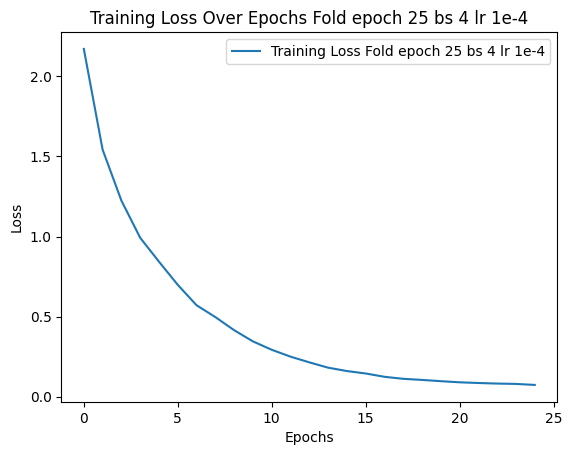

  0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_4497/2159941939.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  questions_tensor = [torch.tensor(question) for question in questions]
100%|██████████| 163/163 [01:56<00:00,  1.40it/s]

Average BLEU Score: 0.7570113351791816


In [18]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 25

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-4)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 25 bs 4 lr 1e-4")
print(f"Average BLEU Score: {testing(model, test_loader)}")

### Train 5

100%|██████████| 143/143 [00:29<00:00,  4.91it/s]


Epoch 1 finished. Loss: 1.8892074573290099


100%|██████████| 143/143 [00:29<00:00,  4.78it/s]


Epoch 2 finished. Loss: 1.4289293376715866


100%|██████████| 143/143 [00:29<00:00,  4.78it/s]


Epoch 3 finished. Loss: 1.2033143881317618


100%|██████████| 143/143 [00:29<00:00,  4.77it/s]


Epoch 4 finished. Loss: 1.0074036348532964


100%|██████████| 143/143 [00:29<00:00,  4.81it/s]


Epoch 5 finished. Loss: 0.8856199629656918


100%|██████████| 143/143 [00:30<00:00,  4.74it/s]


Epoch 6 finished. Loss: 0.7507924735546112


100%|██████████| 143/143 [00:29<00:00,  4.77it/s]


Epoch 7 finished. Loss: 0.6566630197571708


100%|██████████| 143/143 [00:29<00:00,  4.87it/s]


Epoch 8 finished. Loss: 0.5890463522889398


100%|██████████| 143/143 [00:29<00:00,  4.79it/s]


Epoch 9 finished. Loss: 0.5047914011703505


100%|██████████| 143/143 [00:30<00:00,  4.74it/s]


Epoch 10 finished. Loss: 0.44491132499871555


100%|██████████| 143/143 [00:30<00:00,  4.67it/s]


Epoch 11 finished. Loss: 0.38776075350237893


100%|██████████| 143/143 [00:29<00:00,  4.83it/s]


Epoch 12 finished. Loss: 0.3561868079892405


100%|██████████| 143/143 [00:29<00:00,  4.78it/s]


Epoch 13 finished. Loss: 0.3043528859327723


100%|██████████| 143/143 [00:29<00:00,  4.77it/s]


Epoch 14 finished. Loss: 0.2632159402633047


100%|██████████| 143/143 [00:30<00:00,  4.76it/s]


Epoch 15 finished. Loss: 0.22872190057606132


100%|██████████| 143/143 [00:29<00:00,  4.82it/s]


Epoch 16 finished. Loss: 0.2071778278771814


100%|██████████| 143/143 [00:29<00:00,  4.84it/s]


Epoch 17 finished. Loss: 0.18216374198665153


100%|██████████| 143/143 [00:30<00:00,  4.73it/s]


Epoch 18 finished. Loss: 0.15815680614718192


100%|██████████| 143/143 [00:30<00:00,  4.76it/s]


Epoch 19 finished. Loss: 0.13995812041359348


100%|██████████| 143/143 [00:30<00:00,  4.66it/s]


Epoch 20 finished. Loss: 0.12174182942697218


100%|██████████| 143/143 [00:29<00:00,  4.78it/s]


Epoch 21 finished. Loss: 0.11707392183842359


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 22 finished. Loss: 0.10539477196085703


100%|██████████| 143/143 [00:29<00:00,  4.79it/s]


Epoch 23 finished. Loss: 0.09543888687670647


100%|██████████| 143/143 [00:30<00:00,  4.67it/s]


Epoch 24 finished. Loss: 0.08436650053396091


100%|██████████| 143/143 [00:30<00:00,  4.69it/s]


Epoch 25 finished. Loss: 0.07639237774627192


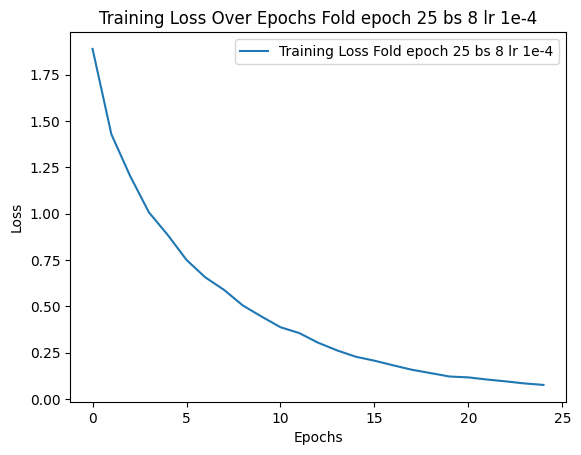

  0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_4497/2159941939.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  questions_tensor = [torch.tensor(question) for question in questions]
100%|██████████| 163/163 [01:58<00:00,  1.38it/s]

Average BLEU Score: 0.7591923027987877


In [19]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 25

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-4)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 25 bs 8 lr 1e-4")
print(f"Average BLEU Score: {testing(model, test_loader)}")

### Train 6

100%|██████████| 285/285 [00:27<00:00, 10.36it/s]


Epoch 1 finished. Loss: 2.5706096176515545


100%|██████████| 285/285 [00:27<00:00, 10.47it/s]


Epoch 2 finished. Loss: 2.2765312943542213


100%|██████████| 285/285 [00:27<00:00, 10.32it/s]


Epoch 3 finished. Loss: 2.1252738492530687


100%|██████████| 285/285 [00:27<00:00, 10.26it/s]


Epoch 4 finished. Loss: 2.018455659715753


100%|██████████| 285/285 [00:27<00:00, 10.24it/s]


Epoch 5 finished. Loss: 1.9198798721296746


100%|██████████| 285/285 [00:27<00:00, 10.23it/s]


Epoch 6 finished. Loss: 1.8218479909394916


100%|██████████| 285/285 [00:27<00:00, 10.22it/s]


Epoch 7 finished. Loss: 1.7521531146869325


100%|██████████| 285/285 [00:27<00:00, 10.29it/s]


Epoch 8 finished. Loss: 1.7081492244151602


100%|██████████| 285/285 [00:28<00:00, 10.16it/s]


Epoch 9 finished. Loss: 1.6173575710832027


100%|██████████| 285/285 [00:27<00:00, 10.29it/s]


Epoch 10 finished. Loss: 1.583119603416376


100%|██████████| 285/285 [00:27<00:00, 10.26it/s]


Epoch 11 finished. Loss: 1.5067227727488468


100%|██████████| 285/285 [00:28<00:00, 10.18it/s]


Epoch 12 finished. Loss: 1.4510871458471868


100%|██████████| 285/285 [00:27<00:00, 10.24it/s]


Epoch 13 finished. Loss: 1.402167204388401


100%|██████████| 285/285 [00:28<00:00, 10.12it/s]


Epoch 14 finished. Loss: 1.3371870013705471


100%|██████████| 285/285 [00:28<00:00, 10.16it/s]


Epoch 15 finished. Loss: 1.3006390682437963


100%|██████████| 285/285 [00:27<00:00, 10.29it/s]


Epoch 16 finished. Loss: 1.278231327993828


100%|██████████| 285/285 [00:28<00:00, 10.17it/s]


Epoch 17 finished. Loss: 1.2169959176004979


100%|██████████| 285/285 [00:27<00:00, 10.28it/s]


Epoch 18 finished. Loss: 1.2074589317305047


100%|██████████| 285/285 [00:27<00:00, 10.33it/s]


Epoch 19 finished. Loss: 1.185272045616518


100%|██████████| 285/285 [00:28<00:00, 10.17it/s]


Epoch 20 finished. Loss: 1.1186151224270202


100%|██████████| 285/285 [00:27<00:00, 10.30it/s]


Epoch 21 finished. Loss: 1.100752600243217


100%|██████████| 285/285 [00:28<00:00, 10.17it/s]


Epoch 22 finished. Loss: 1.0555054917670132


100%|██████████| 285/285 [00:27<00:00, 10.34it/s]


Epoch 23 finished. Loss: 1.0489021552236457


100%|██████████| 285/285 [00:28<00:00, 10.15it/s]


Epoch 24 finished. Loss: 0.9945306725669325


100%|██████████| 285/285 [00:28<00:00, 10.10it/s]


Epoch 25 finished. Loss: 0.9685419539610545


100%|██████████| 285/285 [00:28<00:00, 10.10it/s]


Epoch 26 finished. Loss: 0.9331156106371629


100%|██████████| 285/285 [00:28<00:00, 10.07it/s]


Epoch 27 finished. Loss: 0.916101485490799


100%|██████████| 285/285 [00:27<00:00, 10.31it/s]


Epoch 28 finished. Loss: 0.926122063450646


100%|██████████| 285/285 [00:27<00:00, 10.21it/s]


Epoch 29 finished. Loss: 0.8780760410584901


100%|██████████| 285/285 [00:27<00:00, 10.18it/s]


Epoch 30 finished. Loss: 0.8579931254972492


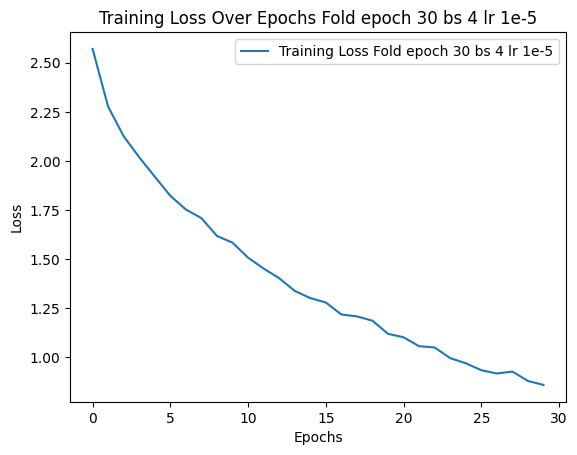

  0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_4497/2159941939.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  questions_tensor = [torch.tensor(question) for question in questions]
100%|██████████| 163/163 [01:31<00:00,  1.78it/s]

Average BLEU Score: 0.7873045085409582


In [20]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 30

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 30 bs 4 lr 1e-5")
print(f"Average BLEU Score: {testing(model, test_loader)}")

### Train 7

100%|██████████| 143/143 [00:29<00:00,  4.83it/s]


Epoch 1 finished. Loss: 2.228928785224061


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 2 finished. Loss: 1.8940918228842996


100%|██████████| 143/143 [00:29<00:00,  4.89it/s]


Epoch 3 finished. Loss: 1.8344020601752755


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 4 finished. Loss: 1.729891945432116


100%|██████████| 143/143 [00:30<00:00,  4.72it/s]


Epoch 5 finished. Loss: 1.6623683000777985


100%|██████████| 143/143 [00:29<00:00,  4.82it/s]


Epoch 6 finished. Loss: 1.6479932315699704


100%|██████████| 143/143 [00:30<00:00,  4.77it/s]


Epoch 7 finished. Loss: 1.587176973586316


100%|██████████| 143/143 [00:29<00:00,  4.84it/s]


Epoch 8 finished. Loss: 1.5738893884878893


100%|██████████| 143/143 [00:30<00:00,  4.72it/s]


Epoch 9 finished. Loss: 1.4759335205271527


100%|██████████| 143/143 [00:29<00:00,  4.82it/s]


Epoch 10 finished. Loss: 1.489178328247337


100%|██████████| 143/143 [00:30<00:00,  4.70it/s]


Epoch 11 finished. Loss: 1.4056672174613793


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 12 finished. Loss: 1.3826377696090646


100%|██████████| 143/143 [00:30<00:00,  4.70it/s]


Epoch 13 finished. Loss: 1.331984478693742


100%|██████████| 143/143 [00:29<00:00,  4.82it/s]


Epoch 14 finished. Loss: 1.327936424242033


100%|██████████| 143/143 [00:29<00:00,  4.87it/s]


Epoch 15 finished. Loss: 1.3161371362792862


100%|██████████| 143/143 [00:29<00:00,  4.80it/s]


Epoch 16 finished. Loss: 1.250298675540444


100%|██████████| 143/143 [00:29<00:00,  4.84it/s]


Epoch 17 finished. Loss: 1.2477774103204686


100%|██████████| 143/143 [00:30<00:00,  4.70it/s]


Epoch 18 finished. Loss: 1.1665455773993805


100%|██████████| 143/143 [00:29<00:00,  4.89it/s]


Epoch 19 finished. Loss: 1.1973585519757304


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 20 finished. Loss: 1.1287112154743888


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 21 finished. Loss: 1.114519130933535


100%|██████████| 143/143 [00:29<00:00,  4.79it/s]


Epoch 22 finished. Loss: 1.077567225152796


100%|██████████| 143/143 [00:30<00:00,  4.77it/s]


Epoch 23 finished. Loss: 1.0419548099691218


100%|██████████| 143/143 [00:30<00:00,  4.71it/s]


Epoch 24 finished. Loss: 1.0070007193338621


100%|██████████| 143/143 [00:30<00:00,  4.71it/s]


Epoch 25 finished. Loss: 0.9881700500324889


100%|██████████| 143/143 [00:30<00:00,  4.73it/s]


Epoch 26 finished. Loss: 0.9711897408628797


100%|██████████| 143/143 [00:29<00:00,  4.78it/s]


Epoch 27 finished. Loss: 0.949533495661262


100%|██████████| 143/143 [00:29<00:00,  4.86it/s]


Epoch 28 finished. Loss: 0.9601144969880164


100%|██████████| 143/143 [00:30<00:00,  4.69it/s]


Epoch 29 finished. Loss: 0.8969167693928405


100%|██████████| 143/143 [00:29<00:00,  4.80it/s]


Epoch 30 finished. Loss: 0.9001936366508058


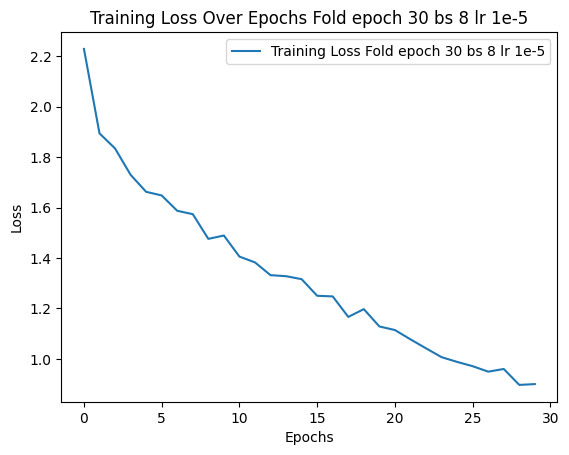

  0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_4497/2159941939.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  questions_tensor = [torch.tensor(question) for question in questions]
100%|██████████| 163/163 [01:19<00:00,  2.05it/s]

Average BLEU Score: 0.7922752511454305


In [21]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 30

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 30 bs 8 lr 1e-5")
print(f"Average BLEU Score: {testing(model, test_loader)}")

### Train 8

100%|██████████| 285/285 [00:27<00:00, 10.40it/s]


Epoch 1 finished. Loss: 2.2090251826403433


100%|██████████| 285/285 [00:28<00:00, 10.18it/s]


Epoch 2 finished. Loss: 1.5933028131200557


100%|██████████| 285/285 [00:27<00:00, 10.31it/s]


Epoch 3 finished. Loss: 1.2932369860117896


100%|██████████| 285/285 [00:27<00:00, 10.27it/s]


Epoch 4 finished. Loss: 1.0564128006759443


100%|██████████| 285/285 [00:27<00:00, 10.18it/s]


Epoch 5 finished. Loss: 0.8610479352767008


100%|██████████| 285/285 [00:27<00:00, 10.23it/s]


Epoch 6 finished. Loss: 0.7361488750629258


100%|██████████| 285/285 [00:27<00:00, 10.23it/s]


Epoch 7 finished. Loss: 0.618174160807802


100%|██████████| 285/285 [00:27<00:00, 10.39it/s]


Epoch 8 finished. Loss: 0.5387745755806304


100%|██████████| 285/285 [00:27<00:00, 10.36it/s]


Epoch 9 finished. Loss: 0.44405320454062075


100%|██████████| 285/285 [00:27<00:00, 10.23it/s]


Epoch 10 finished. Loss: 0.3706770007809003


100%|██████████| 285/285 [00:27<00:00, 10.38it/s]


Epoch 11 finished. Loss: 0.3194922038860488


100%|██████████| 285/285 [00:28<00:00, 10.08it/s]


Epoch 12 finished. Loss: 0.255873190755384


100%|██████████| 285/285 [00:27<00:00, 10.24it/s]


Epoch 13 finished. Loss: 0.2224616902439218


100%|██████████| 285/285 [00:27<00:00, 10.20it/s]


Epoch 14 finished. Loss: 0.19628470005434856


100%|██████████| 285/285 [00:27<00:00, 10.18it/s]


Epoch 15 finished. Loss: 0.1691784947064885


100%|██████████| 285/285 [00:27<00:00, 10.33it/s]


Epoch 16 finished. Loss: 0.14997467087549077


100%|██████████| 285/285 [00:27<00:00, 10.22it/s]


Epoch 17 finished. Loss: 0.13195791729448134


100%|██████████| 285/285 [00:27<00:00, 10.32it/s]


Epoch 18 finished. Loss: 0.11959059807030778


100%|██████████| 285/285 [00:27<00:00, 10.30it/s]


Epoch 19 finished. Loss: 0.10721883988824853


100%|██████████| 285/285 [00:27<00:00, 10.23it/s]


Epoch 20 finished. Loss: 0.10035605874370064


100%|██████████| 285/285 [00:27<00:00, 10.20it/s]


Epoch 21 finished. Loss: 0.0937967710000904


100%|██████████| 285/285 [00:27<00:00, 10.21it/s]


Epoch 22 finished. Loss: 0.0870570230902287


100%|██████████| 285/285 [00:28<00:00, 10.11it/s]


Epoch 23 finished. Loss: 0.08029144703034768


100%|██████████| 285/285 [00:28<00:00, 10.14it/s]


Epoch 24 finished. Loss: 0.07706729417438046


100%|██████████| 285/285 [00:28<00:00, 10.14it/s]


Epoch 25 finished. Loss: 0.07563003087252901


100%|██████████| 285/285 [00:28<00:00, 10.18it/s]


Epoch 26 finished. Loss: 0.0689197930262277


100%|██████████| 285/285 [00:27<00:00, 10.35it/s]


Epoch 27 finished. Loss: 0.0693624868662211


100%|██████████| 285/285 [00:28<00:00, 10.17it/s]


Epoch 28 finished. Loss: 0.06485534844299158


100%|██████████| 285/285 [00:27<00:00, 10.20it/s]


Epoch 29 finished. Loss: 0.06423464201782879


100%|██████████| 285/285 [00:27<00:00, 10.35it/s]

Epoch 30 finished. Loss: 0.06320706734662516


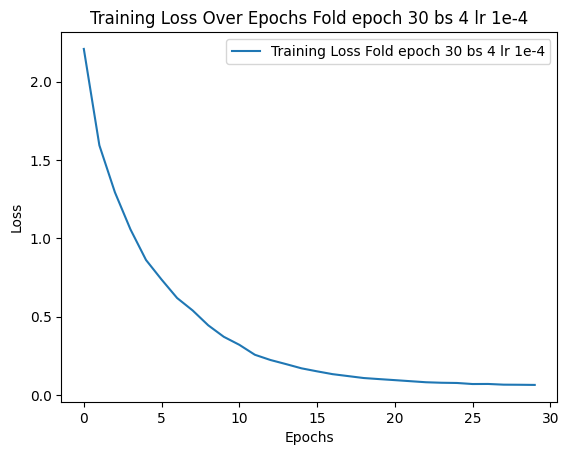

  0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_4497/2159941939.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  questions_tensor = [torch.tensor(question) for question in questions]
100%|██████████| 163/163 [01:51<00:00,  1.47it/s]

Average BLEU Score: 0.7610815726671999


In [22]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 30

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-4)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 30 bs 4 lr 1e-4")
print(f"Average BLEU Score: {testing(model, test_loader)}")

### Train 9

100%|██████████| 143/143 [00:29<00:00,  4.86it/s]


Epoch 1 finished. Loss: 1.9177556375523548


100%|██████████| 143/143 [00:30<00:00,  4.76it/s]


Epoch 2 finished. Loss: 1.466755088809487


100%|██████████| 143/143 [00:29<00:00,  4.86it/s]


Epoch 3 finished. Loss: 1.2446758396975643


100%|██████████| 143/143 [00:30<00:00,  4.74it/s]


Epoch 4 finished. Loss: 1.0319328243499035


100%|██████████| 143/143 [00:30<00:00,  4.70it/s]


Epoch 5 finished. Loss: 0.8774257683670604


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 6 finished. Loss: 0.7752531885683953


100%|██████████| 143/143 [00:30<00:00,  4.70it/s]


Epoch 7 finished. Loss: 0.6714626238062665


100%|██████████| 143/143 [00:30<00:00,  4.65it/s]


Epoch 8 finished. Loss: 0.5849749905454529


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 9 finished. Loss: 0.5297698148272254


100%|██████████| 143/143 [00:30<00:00,  4.76it/s]


Epoch 10 finished. Loss: 0.4690095082029596


100%|██████████| 143/143 [00:30<00:00,  4.75it/s]


Epoch 11 finished. Loss: 0.4184224541995909


100%|██████████| 143/143 [00:30<00:00,  4.77it/s]


Epoch 12 finished. Loss: 0.3703445843779124


100%|██████████| 143/143 [00:30<00:00,  4.74it/s]


Epoch 13 finished. Loss: 0.32476820812358725


100%|██████████| 143/143 [00:30<00:00,  4.73it/s]


Epoch 14 finished. Loss: 0.27748909816666917


100%|██████████| 143/143 [00:29<00:00,  4.80it/s]


Epoch 15 finished. Loss: 0.2509040798653256


100%|██████████| 143/143 [00:29<00:00,  4.86it/s]


Epoch 16 finished. Loss: 0.22078334847530284


100%|██████████| 143/143 [00:30<00:00,  4.68it/s]


Epoch 17 finished. Loss: 0.18396339721821406


100%|██████████| 143/143 [00:30<00:00,  4.73it/s]


Epoch 18 finished. Loss: 0.16848342855285098


100%|██████████| 143/143 [00:30<00:00,  4.76it/s]


Epoch 19 finished. Loss: 0.15298444793357716


100%|██████████| 143/143 [00:30<00:00,  4.66it/s]


Epoch 20 finished. Loss: 0.12932624076525648


100%|██████████| 143/143 [00:30<00:00,  4.74it/s]


Epoch 21 finished. Loss: 0.12446087476361048


100%|██████████| 143/143 [00:30<00:00,  4.76it/s]


Epoch 22 finished. Loss: 0.11210469396172704


100%|██████████| 143/143 [00:29<00:00,  4.92it/s]


Epoch 23 finished. Loss: 0.1049265071905993


100%|██████████| 143/143 [00:30<00:00,  4.72it/s]


Epoch 24 finished. Loss: 0.09020577381540845


100%|██████████| 143/143 [00:30<00:00,  4.66it/s]


Epoch 25 finished. Loss: 0.08412797145962299


100%|██████████| 143/143 [00:29<00:00,  4.89it/s]


Epoch 26 finished. Loss: 0.08748250980894048


100%|██████████| 143/143 [00:30<00:00,  4.69it/s]


Epoch 27 finished. Loss: 0.07588476786663483


100%|██████████| 143/143 [00:29<00:00,  4.90it/s]


Epoch 28 finished. Loss: 0.07324045339039156


100%|██████████| 143/143 [00:30<00:00,  4.73it/s]


Epoch 29 finished. Loss: 0.06541878335386306


100%|██████████| 143/143 [00:29<00:00,  4.78it/s]


Epoch 30 finished. Loss: 0.06461564562172739


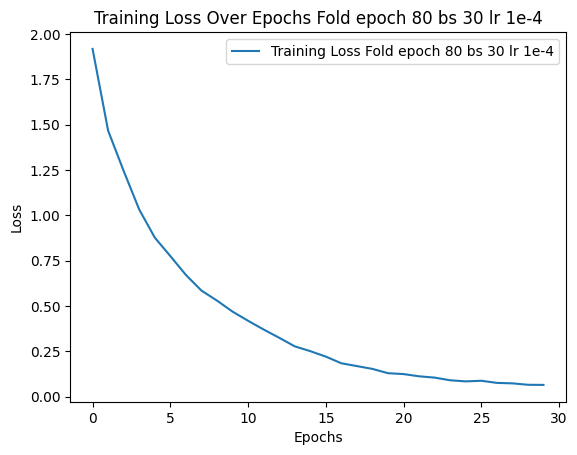

  0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_4497/2159941939.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  questions_tensor = [torch.tensor(question) for question in questions]
100%|██████████| 163/163 [02:29<00:00,  1.09it/s]

Average BLEU Score: 0.7435288316558909


In [23]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 30

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-4)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 80 bs 30 lr 1e-4")
print(f"Average BLEU Score: {testing(model, test_loader)}")

### Train 10

100%|██████████| 570/570 [00:31<00:00, 17.82it/s]


Epoch 1 finished. Loss: 3.6292670224842274


100%|██████████| 570/570 [00:32<00:00, 17.35it/s]


Epoch 2 finished. Loss: 3.172854440672356


100%|██████████| 570/570 [00:32<00:00, 17.67it/s]


Epoch 3 finished. Loss: 3.048540042366898


100%|██████████| 570/570 [00:32<00:00, 17.74it/s]


Epoch 4 finished. Loss: 3.032069462433196


100%|██████████| 570/570 [00:32<00:00, 17.68it/s]


Epoch 5 finished. Loss: 2.9193912627404197


100%|██████████| 570/570 [00:32<00:00, 17.63it/s]


Epoch 6 finished. Loss: 2.899192416040521


100%|██████████| 570/570 [00:32<00:00, 17.81it/s]


Epoch 7 finished. Loss: 2.8550848187061777


100%|██████████| 570/570 [00:32<00:00, 17.68it/s]


Epoch 8 finished. Loss: 2.836634709542258


100%|██████████| 570/570 [00:32<00:00, 17.61it/s]


Epoch 9 finished. Loss: 2.772477056059921


100%|██████████| 570/570 [00:32<00:00, 17.60it/s]


Epoch 10 finished. Loss: 2.7500629025593137


100%|██████████| 570/570 [00:32<00:00, 17.74it/s]


Epoch 11 finished. Loss: 2.7073147694269815


100%|██████████| 570/570 [00:32<00:00, 17.39it/s]


Epoch 12 finished. Loss: 2.6778010096466334


100%|██████████| 570/570 [00:32<00:00, 17.52it/s]


Epoch 13 finished. Loss: 2.6517710997347246


100%|██████████| 570/570 [00:32<00:00, 17.70it/s]


Epoch 14 finished. Loss: 2.6204516168226277


100%|██████████| 570/570 [00:32<00:00, 17.56it/s]


Epoch 15 finished. Loss: 2.614295158260747


100%|██████████| 570/570 [00:32<00:00, 17.75it/s]


Epoch 16 finished. Loss: 2.570636799251824


100%|██████████| 570/570 [00:32<00:00, 17.46it/s]


Epoch 17 finished. Loss: 2.5606184913401018


100%|██████████| 570/570 [00:32<00:00, 17.63it/s]


Epoch 18 finished. Loss: 2.5364546466291995


100%|██████████| 570/570 [00:32<00:00, 17.71it/s]


Epoch 19 finished. Loss: 2.5267734883124366


100%|██████████| 570/570 [00:32<00:00, 17.54it/s]


Epoch 20 finished. Loss: 2.5093840297899748


100%|██████████| 570/570 [00:31<00:00, 17.88it/s]


Epoch 21 finished. Loss: 2.510803636542538


100%|██████████| 570/570 [00:32<00:00, 17.68it/s]


Epoch 22 finished. Loss: 2.4561936487231337


100%|██████████| 570/570 [00:32<00:00, 17.71it/s]


Epoch 23 finished. Loss: 2.4640157099355733


100%|██████████| 570/570 [00:32<00:00, 17.66it/s]


Epoch 24 finished. Loss: 2.4285526742014967


100%|██████████| 570/570 [00:32<00:00, 17.62it/s]


Epoch 25 finished. Loss: 2.409867547269453


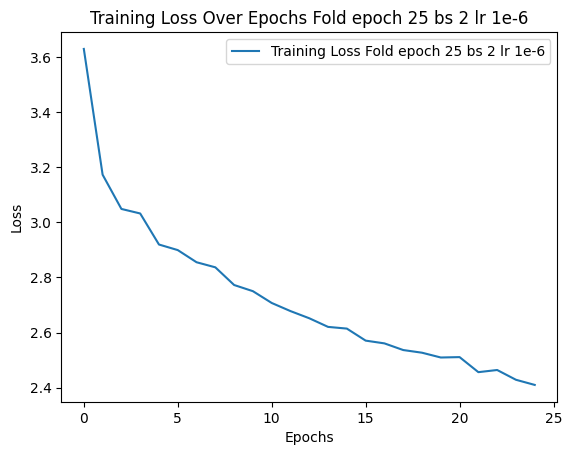

  0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_4497/2159941939.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  questions_tensor = [torch.tensor(question) for question in questions]
100%|██████████| 163/163 [02:06<00:00,  1.29it/s]

Average BLEU Score: 0.790179774697161


In [24]:
model, tokenizer = prepare_model()
#prepare data
train_size = round(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]
train_dataset = QADataset(tokenizer, train_data, 512)
test_dataset = QADataset(tokenizer, test_data, 512, train=False)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn2)

#hyper parameters
epochs = 25

#optimizer
optimizer = AdamW(model.parameters(), lr=1e-6)

#loss function
loss_fn = torch.nn.CrossEntropyLoss()

epoch_losses = training(model, train_loader, epochs, optimizer, loss_fn)
plot(epoch_losses, "epoch 25 bs 2 lr 1e-6")
print(f"Average BLEU Score: {testing(model, test_loader)}")